## Weakly Supervised Instance Segmentation using Class Peak Response 
### Demo code

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.misc import imresize

Access PRM through [Nest](https://github.com/ZhouYanzhao/Nest)

In [4]:
from nest import modules, run_tasks

### Train a PRM-augmented classification network using image-level labels

In [ ]:
run_tasks('./config.yml')

### Inference setup

In [6]:
# object categories
class_names = modules.pascal_voc_object_categories()
print('Object categories: ' + ', '.join(class_names))

Object categories: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor


In [7]:
image_size = 448
# image pre-processor
transformer = modules.image_transform(
    image_size = [image_size, image_size],
    augmentation = dict(),
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])

print(transformer)

Compose(
    Resize(size=(448, 448), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


### Classification networks in fully convolutional manner

In [8]:
backbone = modules.fc_resnet50(num_classes=20, pretrained=False)
print(backbone)

FC_ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, ke

)


### Equipped  with Peak Response Mapping

In [9]:
model = modules.peak_response_mapping(backbone)

In [10]:
# loaded pre-trained weights
model = nn.DataParallel(model)
state = torch.load('./snapshots/model_latest.pt')
model.load_state_dict(state['model'])
model = model.module.cuda()

### Load demo images and pre-computed object proposals

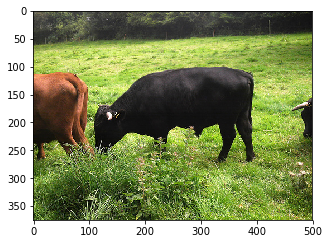

In [11]:
# change the idx to test different samples
idx = 0
raw_img = PIL.Image.open('./data/sample%d.jpg' % idx).convert('RGB')
input_var = transformer(raw_img).unsqueeze(0).cuda().requires_grad_()
with open('./data/sample%d.json' % idx, 'r') as f:
    proposals = list(map(modules.rle_decode, json.load(f)))
# plot raw image
plt.figure(figsize=(5,5))
plt.imshow(raw_img)

### Multi-label classification

In [12]:
model = model.eval()

In [13]:
print('Object categories in the image:')
confidence = model(input_var)
for idx in range(len(class_names)):
    if confidence.data[0, idx] > 0:
        print('    [class_idx: %d] %s (%.2f)' % (idx, class_names[idx], confidence[0, idx]))

Object categories in the image:
    [class_idx: 9] cow (15.69)


### Visual cue extraction

In [14]:
model = model.inference()

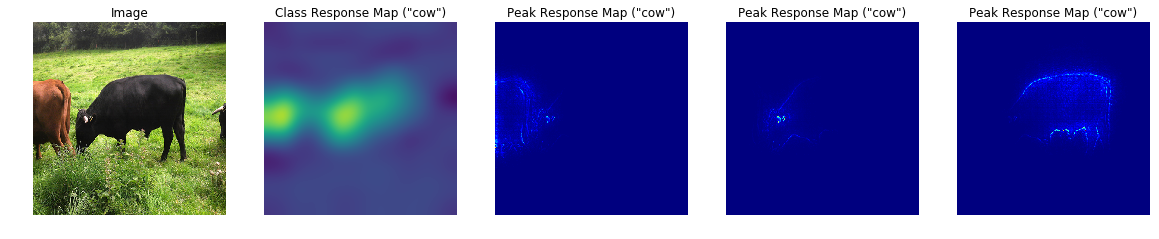

In [15]:
visual_cues = model(input_var)
if visual_cues is None:
    print('No class peak response detected')
else:
    confidence, class_response_maps, class_peak_responses, peak_response_maps = visual_cues
    _, class_idx = torch.max(confidence, dim=1)
    class_idx = class_idx.item()
    num_plots = 2 + len(peak_response_maps)
    f, axarr = plt.subplots(1, num_plots, figsize=(num_plots * 4, 4))
    axarr[0].imshow(imresize(raw_img, (image_size, image_size), interp='bicubic'))
    axarr[0].set_title('Image')
    axarr[0].axis('off')
    axarr[1].imshow(class_response_maps[0, class_idx].cpu(), interpolation='bicubic')
    axarr[1].set_title('Class Response Map ("%s")' % class_names[class_idx])
    axarr[1].axis('off')
    for idx, (prm, peak) in enumerate(sorted(zip(peak_response_maps, class_peak_responses), key=lambda v: v[-1][-1])):
        axarr[idx + 2].imshow(prm.cpu(), cmap=plt.cm.jet)
        axarr[idx + 2].set_title('Peak Response Map ("%s")' % (class_names[peak[1].item()]))
        axarr[idx + 2].axis('off')

### Weakly supervised instance segmentation

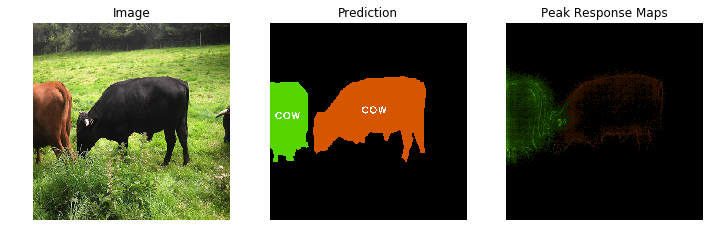

In [16]:
# predict instance masks via proposal retrieval
instance_list = model(input_var, retrieval_cfg=dict(proposals=proposals, param=(0.95, 1e-5, 0.8)))

# visualization
if instance_list is None:
    print('No object detected')
else:
    # peak response maps are merged if they select similar proposals
    vis = modules.prm_visualize(instance_list, class_names=class_names)
    f, axarr = plt.subplots(1, 3, figsize=(12, 5))
    axarr[0].imshow(imresize(raw_img, (image_size, image_size), interp='bicubic'))
    axarr[0].set_title('Image')
    axarr[0].axis('off')
    axarr[1].imshow(vis[0])
    axarr[1].set_title('Prediction')
    axarr[1].axis('off')
    axarr[2].imshow(vis[1])
    axarr[2].set_title('Peak Response Maps')
    axarr[2].axis('off')
    plt.show()